In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from pkasolver.constants import DEVICE
from pkasolver.data import calculate_nr_of_features
from pkasolver.ml import (
    dataset_to_dataloader,
    calculate_performance_of_model_on_data
)
from pkasolver.ml_architecture import GINPairV1 as GINPair 
from scipy.stats import t
from sklearn.metrics import mean_absolute_error, mean_squared_error

def confidence_calculation(sample_list):
    x = np.array(sample_list)
    m = np.median(x)
    s = x.std()
    alpha = 10.0
    lower_p = alpha / 2.0
    lower = np.percentile(sample_list, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(sample_list, upper_p)
    return m, lower, upper


BATCH_SIZE = 512

node_feat_list = [
    "element",
    "formal_charge",
    "hybridization",
    "total_num_Hs",
    "aromatic_tag",
    "total_valence",
    "total_degree",
    "is_in_ring",
    "reaction_center",
    "smarts",
]

edge_feat_list = ["bond_type", "is_conjugated", "rotatable"]
num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

import seaborn as sns
import numpy as np

sns.set_context("talk")

In [2]:
wdr_dir = '.' 

# read training set
with open(
    f"{wdr_dir}/05_chembl_dataset_pyg.pkl",
    "rb",
) as f:
    training_dataset = pickle.load(f)
    
# read fine tuning set
with open(
    f"{wdr_dir}/05_experimental_training_datasets_pyg.pkl",
    "rb",
) as f:
    finetuning_dataset = pickle.load(f)


5994
5994


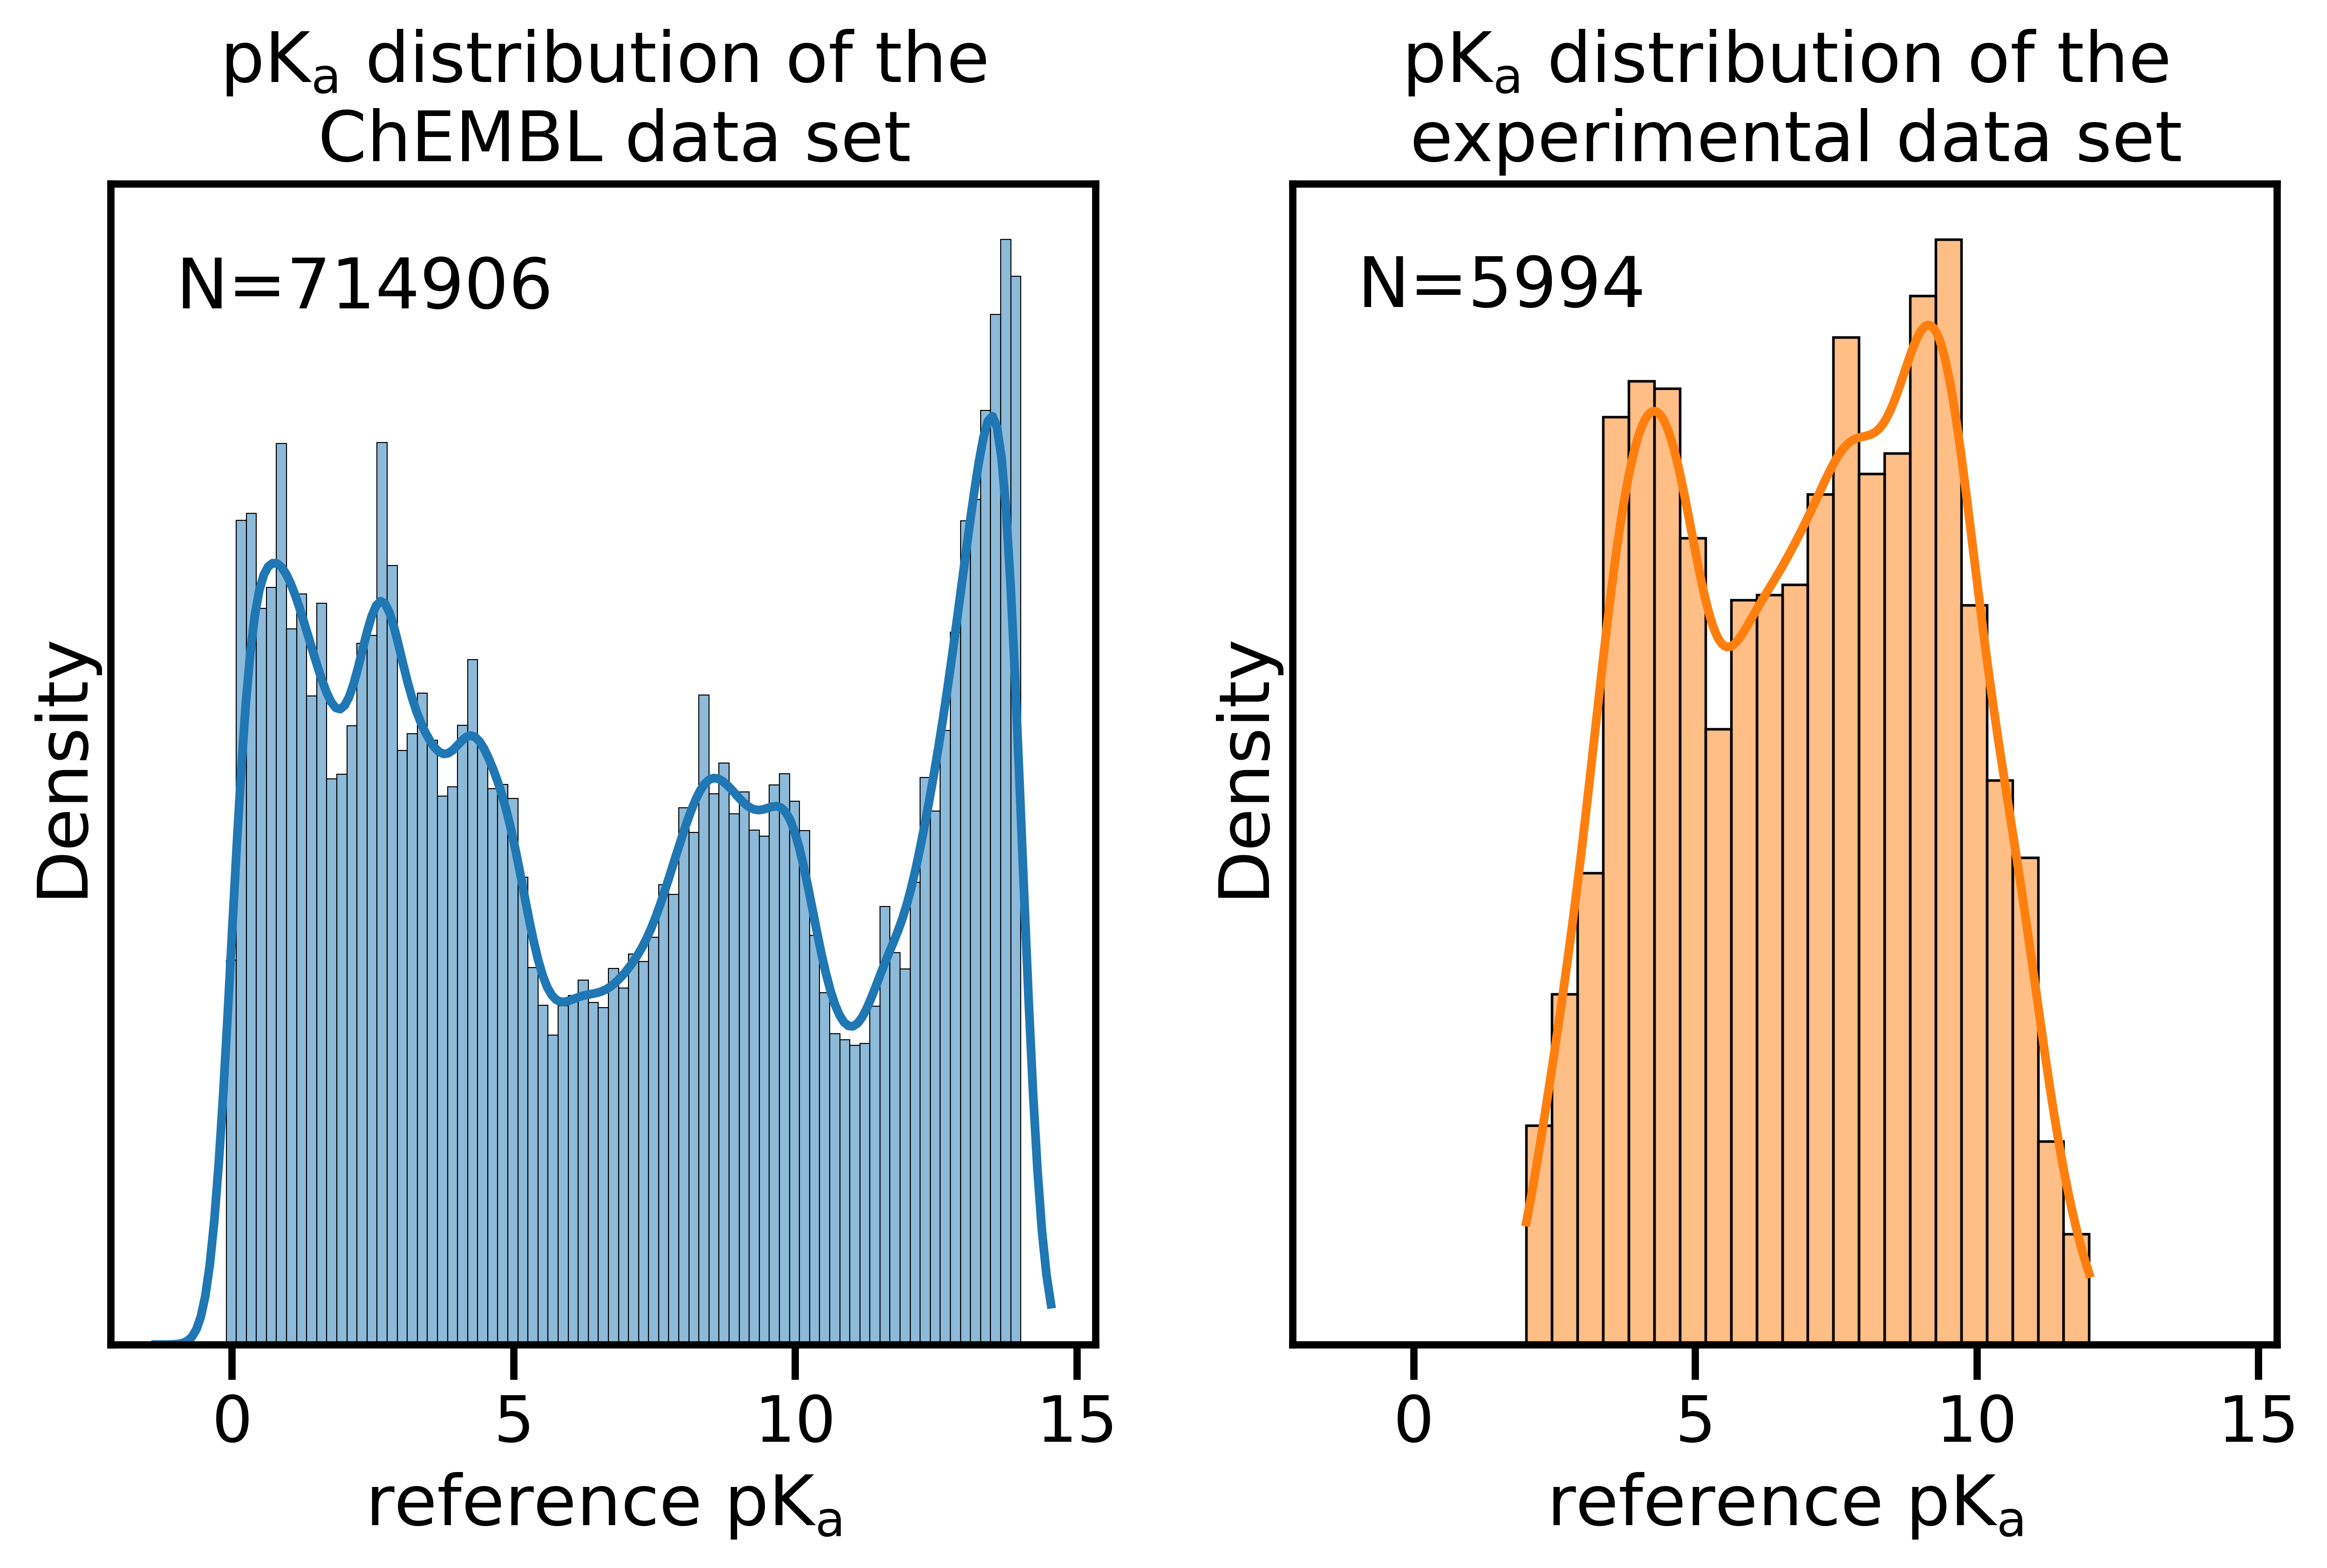

In [10]:
# plot KDE for ChEMBL and experimental data set

sns.set_context("talk")
fig, axs = plt.subplots(1,2, figsize=(10.0, 5.5), dpi=600, sharex=True)
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]

names = []
pka_values = []
for d in training_dataset:
    names.append(d.chembl_id)
    pka_values.append(d.reference_value.item())

sns.histplot(ax=axs[0],data=pka_values, kde=True, stat='density', label=r'ChEMBL data set',color=c1)
axs[0].set_title(r'$pK_{a}$ distribution of the' + '\n ChEMBL data set')
axs[0].get_yaxis().set_ticks([])
axs[0].set_ylabel("Density")
axs[0].set_xlabel(r'reference pK$_{a}$')
axs[0].text(-1.0,0.13,fr'N={len(pka_values)}')

names = []
pka_values = []
for d in finetuning_dataset:
    names.append(d.chembl_id)
    pka_values.append(d.reference_value.item())
print(len(set(names)))
print(len(names))
sns.histplot(ax=axs[1],data=pka_values, kde=True, stat='density', label=r'experimental data set',color=c2)
axs[1].set_title(r'$pK_{a}$ distribution of the' + '\n experimental data set')
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel("Density")
axs[1].set_xlabel(r'reference pK$_{a}$')
axs[1].text(-1.0,0.148, fr'N={len(pka_values)}')
plt.savefig('plots/kde_of_datasets.png')
plt.show()

In [4]:
hidden_channels = 96
nr_of_training_runs = 50
model_class =  GINPair

Attention pooling: False


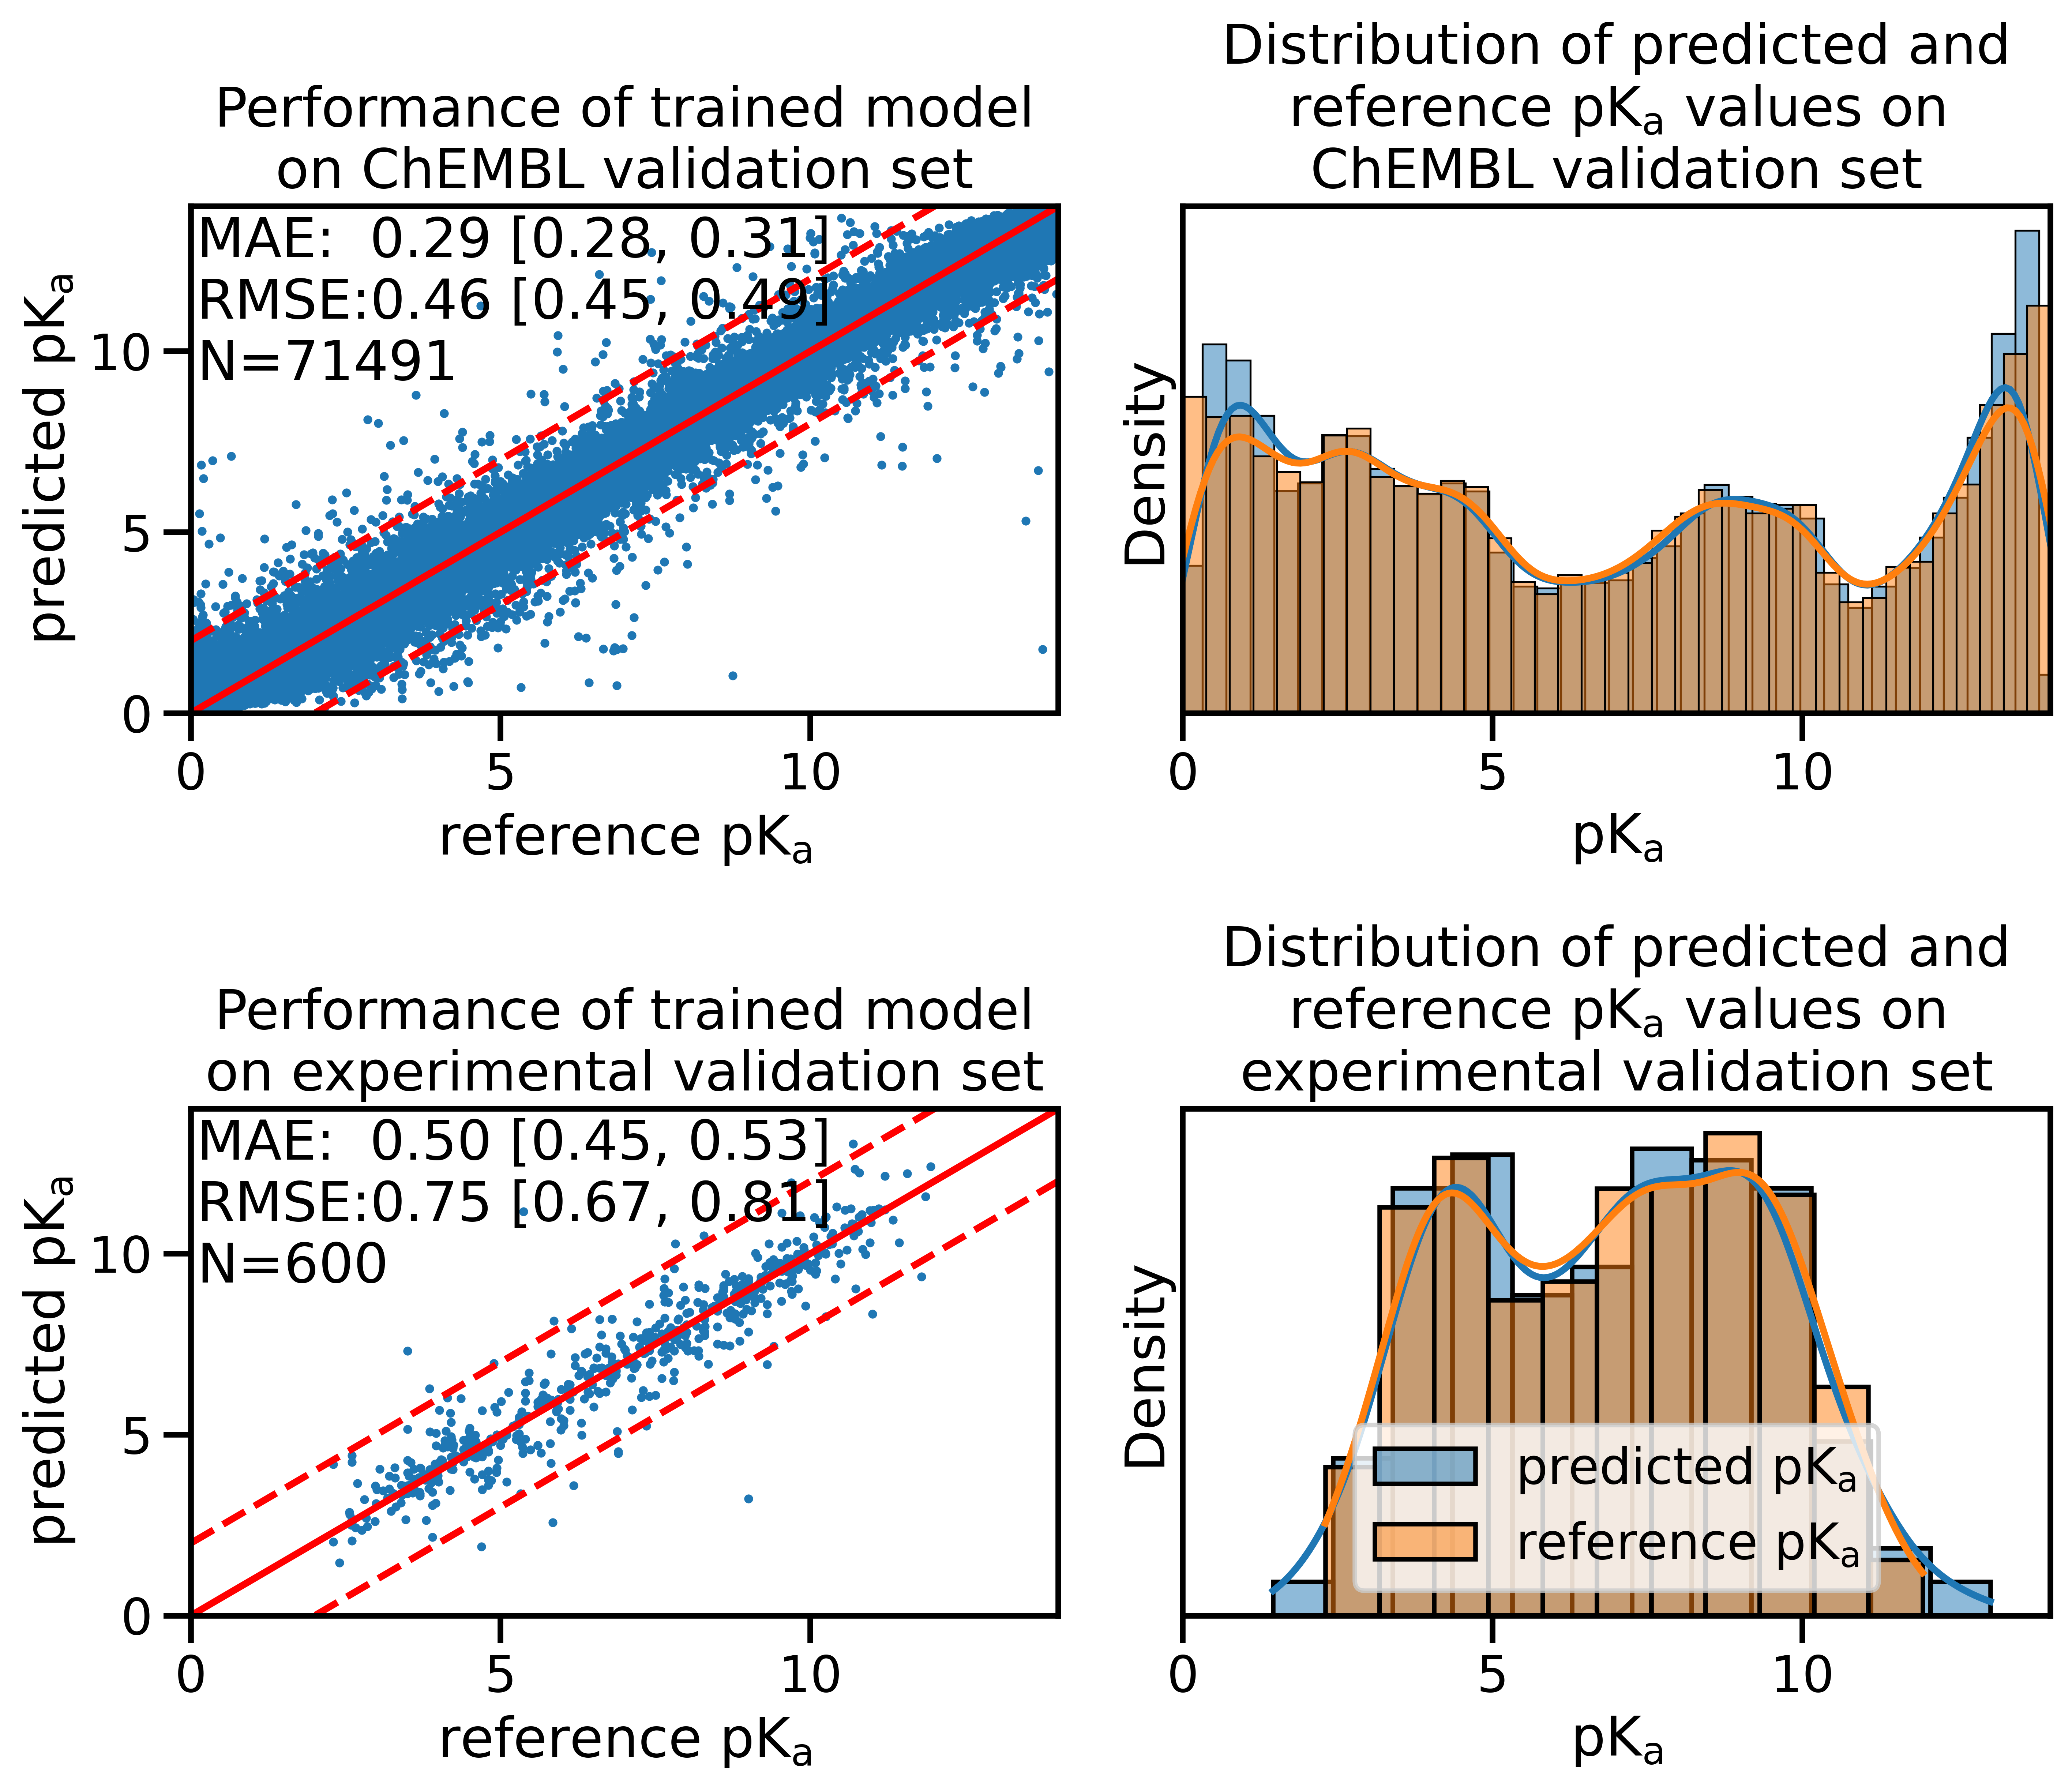

In [5]:
# performance of trained models on validation sets
model_class =  GINPair
model = model_class(
    num_node_features, num_edge_features, hidden_channels=hidden_channels
)

# plot performance of the trained model on the validation set
from sklearn.model_selection import train_test_split

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/pretrained_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    _, validation_dataset = train_test_split(
                training_dataset, test_size=0.1, shuffle=True, random_state=rs
    )
    data = dataset_to_dataloader(validation_dataset, BATCH_SIZE, shuffle=False)    
    x, y = calculate_performance_of_model_on_data(model, data)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(10):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(10):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# set up plot
sns.set_context("talk")
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]
fig, axs = plt.subplots(2,2, figsize=(10.0, 8.5), dpi=600)

# plot
axs[0][0].scatter(val_x[0], r[0], c=c1, marker='o', s=2, alpha=1.)
axs[0][0].set_title('Performance of trained model\non ChEMBL validation set')
axs[0][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'ChEMBL validation set')
axs[0][0].set_xlim(0,14)
axs[0][0].set_ylim(0,14)
axs[0][0].set_xlabel(r'reference pK$_{a}$')
axs[0][0].set_ylabel(r'predicted pK$_{a}$')
axs[0][0].plot([0, 14], [0, 14], c='r')
axs[0][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[0][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[0][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[0][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[0][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[0][1].set_xlim(0,14)
axs[0][1].get_yaxis().set_ticks([])
axs[0][1].set_ylabel("Density")
axs[0][1].set_xlabel(r'pK$_{a}$')

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/fine_tuned_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    _, validation_dataset = train_test_split(
                finetuning_dataset, test_size=0.1, shuffle=True, random_state=rs
    )
    data = dataset_to_dataloader(validation_dataset, BATCH_SIZE, shuffle=False)    

    x, y = calculate_performance_of_model_on_data(model, data)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(10):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(10):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# plot
axs[1][0].scatter(val_x[0], r[0], c=c1, marker='o', s=2, alpha=1.)
axs[1][0].set_title('Performance of trained model\non experimental validation set')
axs[1][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'experimental validation set')
axs[1][0].set_xlim(0,14)
axs[1][0].set_ylim(0,14)
axs[1][0].set_xlabel(r'reference pK$_{a}$')
axs[1][0].set_ylabel(r'predicted pK$_{a}$')
axs[1][0].plot([0, 14], [0, 14], c='r')
axs[1][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[1][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[1][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[1][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[1][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[1][1].set_xlim(0,14)
axs[1][1].get_yaxis().set_ticks([])
axs[1][1].set_ylabel("Density")
axs[1][1].set_xlabel(r'pK$_{a}$')

plt.tight_layout()
plt.legend()
plt.savefig('plots/pretraining_validation_set.png')
plt.show()

Attention pooling: False


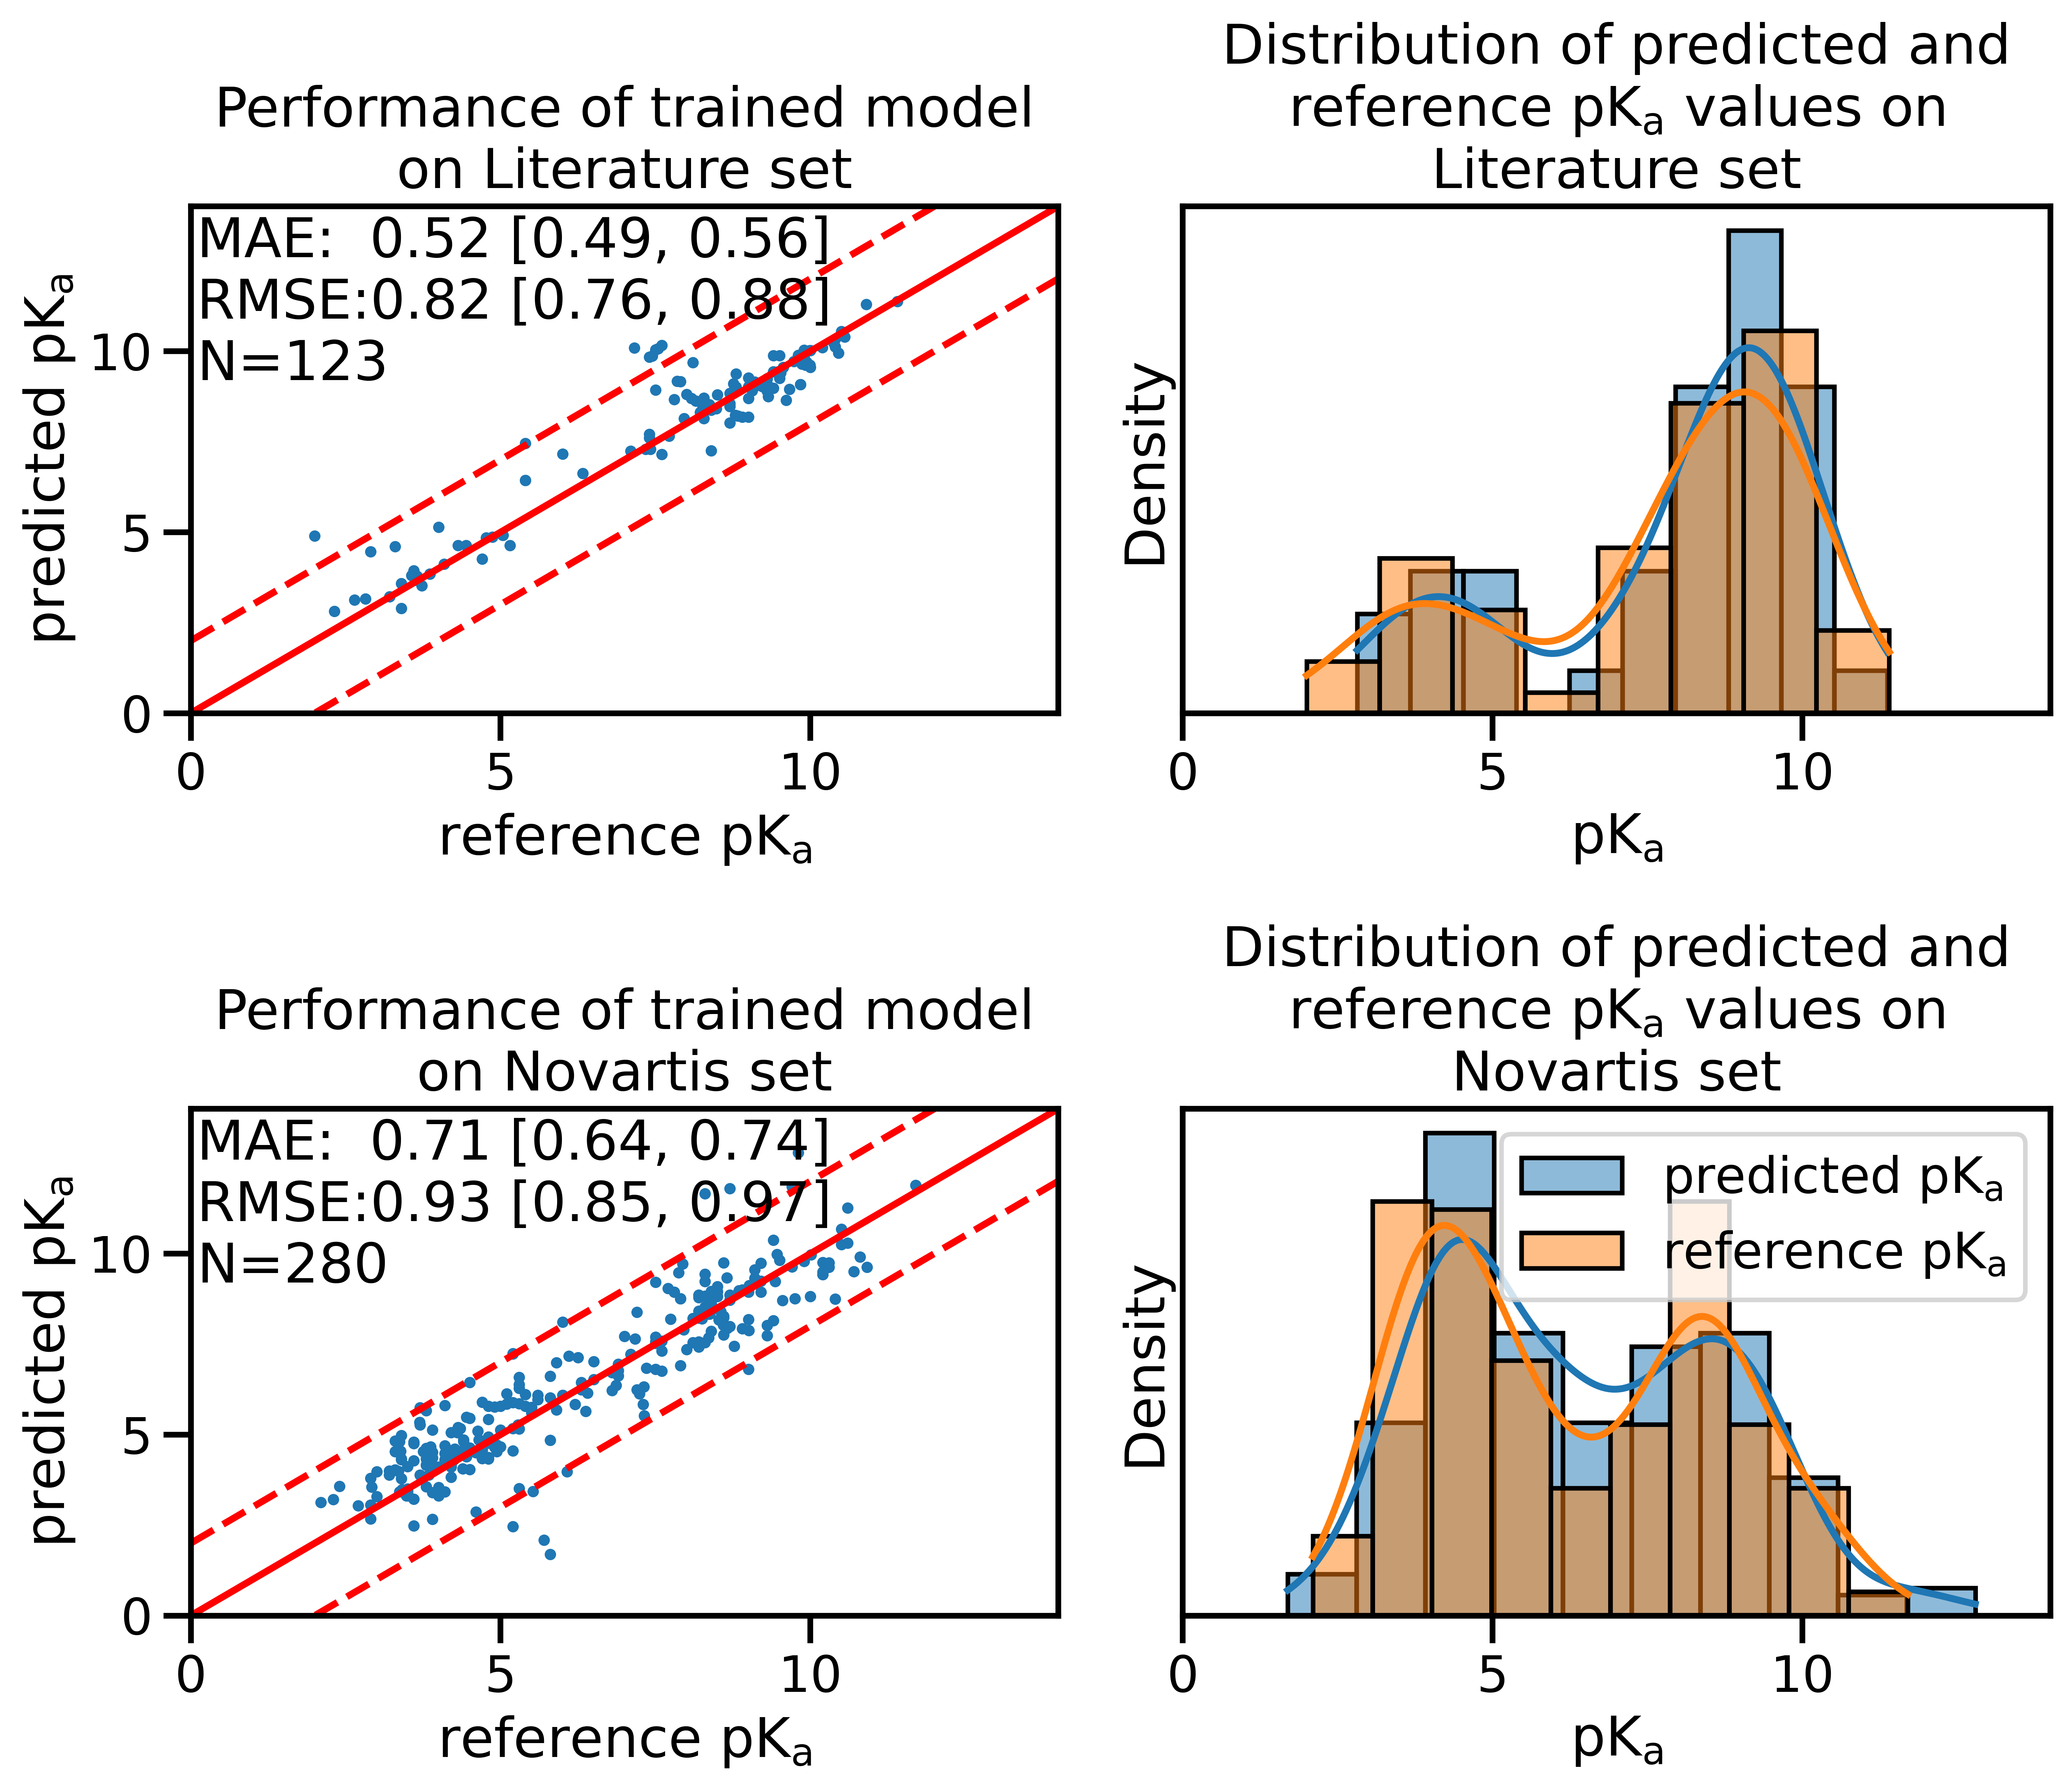

In [6]:
# performance of fine tuned model on test sets
model = model_class(
    num_node_features, num_edge_features, hidden_channels=hidden_channels
)
with open(
    f"{wdr_dir}/05_AvLiLuMoVe_testdata_pyg.pkl",
    "rb",
) as f:
    literature_test_dataset = pickle.load(f)
literature_testdata = dataset_to_dataloader(literature_test_dataset, BATCH_SIZE, shuffle=False)

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/fine_tuned_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    x, y = calculate_performance_of_model_on_data(model, literature_testdata)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# set up plot
sns.set_context("talk")
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]
fig, axs = plt.subplots(2,2, figsize=(10.0, 8.5), dpi=600)

# plot
axs[0][0].scatter(val_x[0], r[0], c=c1, marker='o', s=5, alpha=1.)
axs[0][0].set_title('Performance of trained model\non Literature set')
axs[0][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'Literature set')
axs[0][0].set_xlim(0,14)
axs[0][0].set_ylim(0,14)
axs[0][0].set_xlabel(r'reference pK$_{a}$')
axs[0][0].set_ylabel(r'predicted pK$_{a}$')
axs[0][0].plot([0, 14], [0, 14], c='r')
axs[0][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[0][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[0][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[0][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[0][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[0][1].set_xlim(0,14)
axs[0][1].get_yaxis().set_ticks([])
axs[0][1].set_ylabel("Density")
axs[0][1].set_xlabel(r'pK$_{a}$')


with open(
    f"{wdr_dir}/05_novartis_testdata_pyg.pkl",
    "rb",
) as f:
    literature_test_dataset = pickle.load(f)
novartis_testdata = dataset_to_dataloader(literature_test_dataset, BATCH_SIZE, shuffle=False)

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/fine_tuned_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    x, y = calculate_performance_of_model_on_data(model, novartis_testdata)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# plot
axs[1][0].scatter(val_x[0], r[0], c=c1, marker='o', s=5, alpha=1.)
axs[1][0].set_title('Performance of trained model\non Novartis set')
axs[1][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'Novartis set')
axs[1][0].set_xlim(0,14)
axs[1][0].set_ylim(0,14)
axs[1][0].set_xlabel(r'reference pK$_{a}$')
axs[1][0].set_ylabel(r'predicted pK$_{a}$')
axs[1][0].plot([0, 14], [0, 14], c='r')
axs[1][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[1][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[1][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[1][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[1][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[1][1].set_xlim(0,14)
axs[1][1].get_yaxis().set_ticks([])
axs[1][1].set_ylabel("Density")
axs[1][1].set_xlabel(r'pK$_{a}$')

plt.tight_layout()
plt.legend()
plt.savefig('plots/fine_tuned_model_on_test_set.svg')
plt.show()

Attention pooling: False


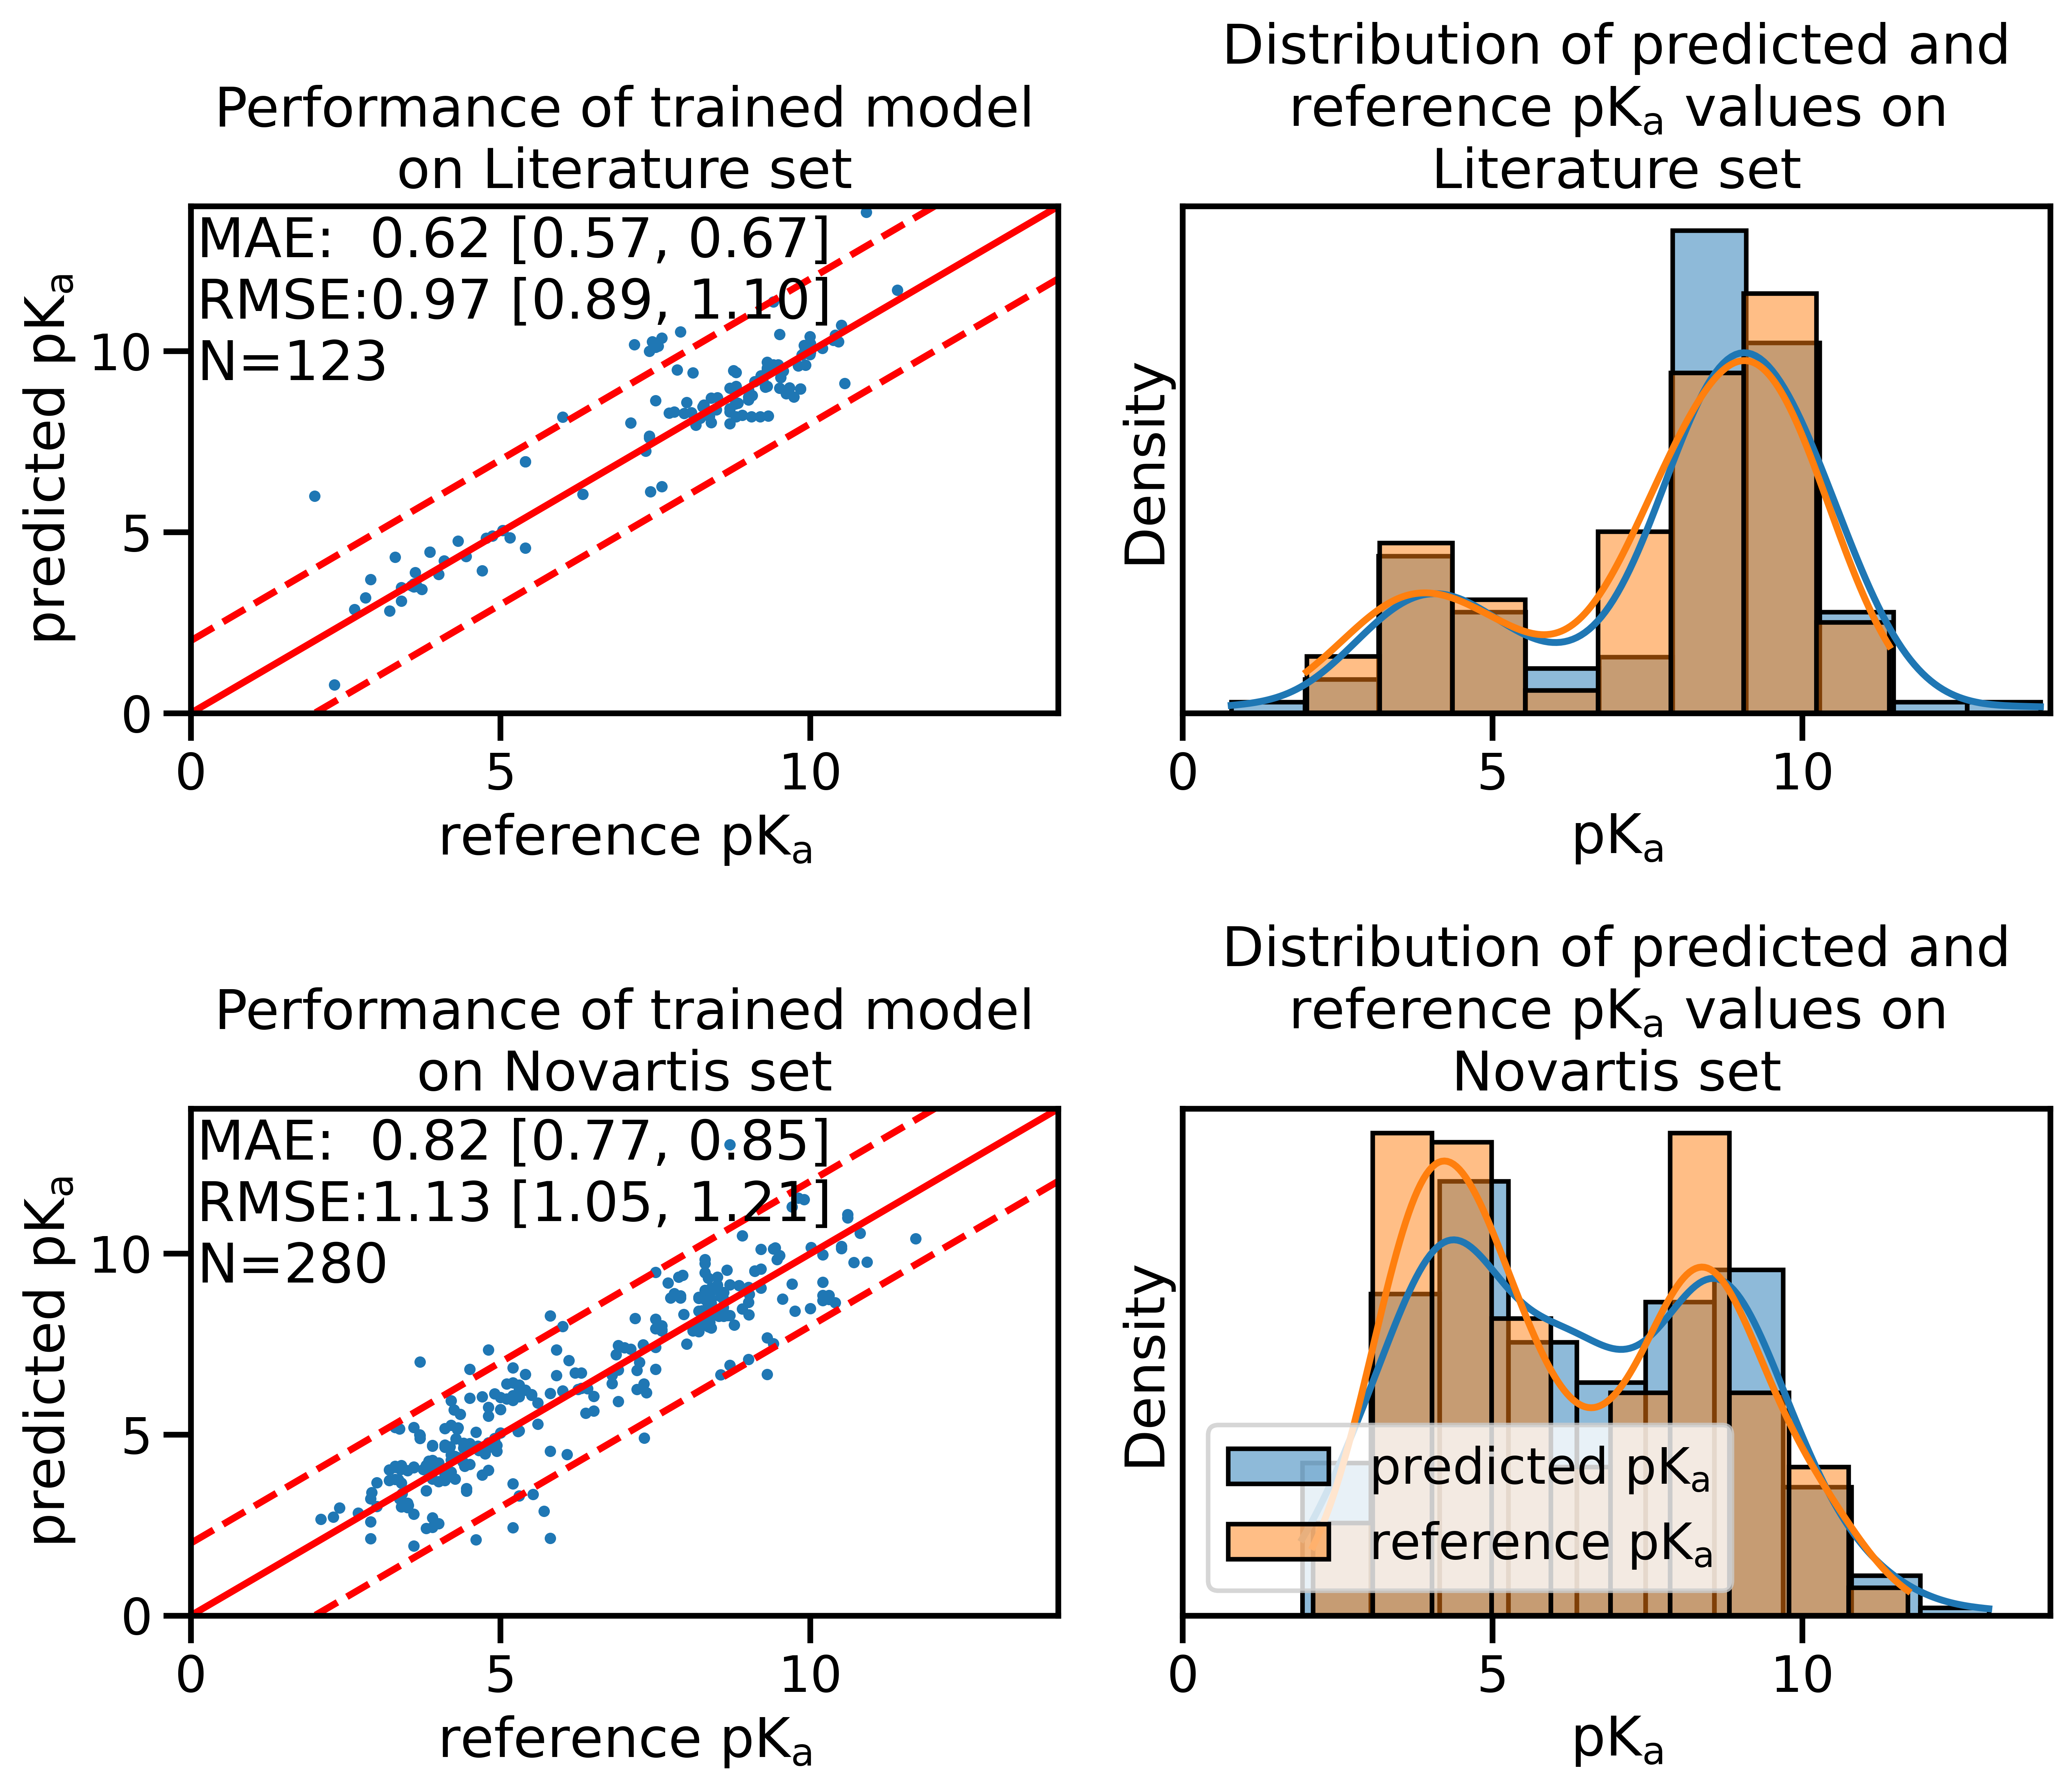

In [7]:
# performance of initally trained model on test sets
model = model_class(
    num_node_features, num_edge_features, hidden_channels=hidden_channels
)
with open(
    f"{wdr_dir}/05_AvLiLuMoVe_testdata_pyg.pkl",
    "rb",
) as f:
    literature_test_dataset = pickle.load(f)
literature_testdata = dataset_to_dataloader(literature_test_dataset, BATCH_SIZE, shuffle=False)

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/pretrained_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    x, y = calculate_performance_of_model_on_data(model, literature_testdata)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# set up plot
sns.set_context("talk")
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]
fig, axs = plt.subplots(2,2, figsize=(10.0, 8.5), dpi=600)

# plot
axs[0][0].scatter(val_x[0], r[0], c=c1, marker='o', s=5, alpha=1.)
axs[0][0].set_title('Performance of trained model\non Literature set')
axs[0][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'Literature set')
axs[0][0].set_xlim(0,14)
axs[0][0].set_ylim(0,14)
axs[0][0].set_xlabel(r'reference pK$_{a}$')
axs[0][0].set_ylabel(r'predicted pK$_{a}$')
axs[0][0].plot([0, 14], [0, 14], c='r')
axs[0][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[0][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[0][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[0][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[0][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[0][1].set_xlim(0,14)
axs[0][1].get_yaxis().set_ticks([])
axs[0][1].set_ylabel("Density")
axs[0][1].set_xlabel(r'pK$_{a}$')


with open(
    f"{wdr_dir}/05_novartis_testdata_pyg.pkl",
    "rb",
) as f:
    literature_test_dataset = pickle.load(f)
novartis_testdata = dataset_to_dataloader(literature_test_dataset, BATCH_SIZE, shuffle=False)

r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/pretrained_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    x, y = calculate_performance_of_model_on_data(model, novartis_testdata)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# plot
axs[1][0].scatter(val_x[0], r[0], c=c1, marker='o', s=5, alpha=1.)
axs[1][0].set_title('Performance of trained model\non Novartis set')
axs[1][1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'Novartis set')
axs[1][0].set_xlim(0,14)
axs[1][0].set_ylim(0,14)
axs[1][0].set_xlabel(r'reference pK$_{a}$')
axs[1][0].set_ylabel(r'predicted pK$_{a}$')
axs[1][0].plot([0, 14], [0, 14], c='r')
axs[1][0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[1][0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[1][0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[1][1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[1][1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[1][1].set_xlim(0,14)
axs[1][1].get_yaxis().set_ticks([])
axs[1][1].set_ylabel("Density")
axs[1][1].set_xlabel(r'pK$_{a}$')

plt.tight_layout()
plt.legend()
plt.savefig('plots/pretrained_model_on_test_set.svg')
plt.show()

Attention pooling: False


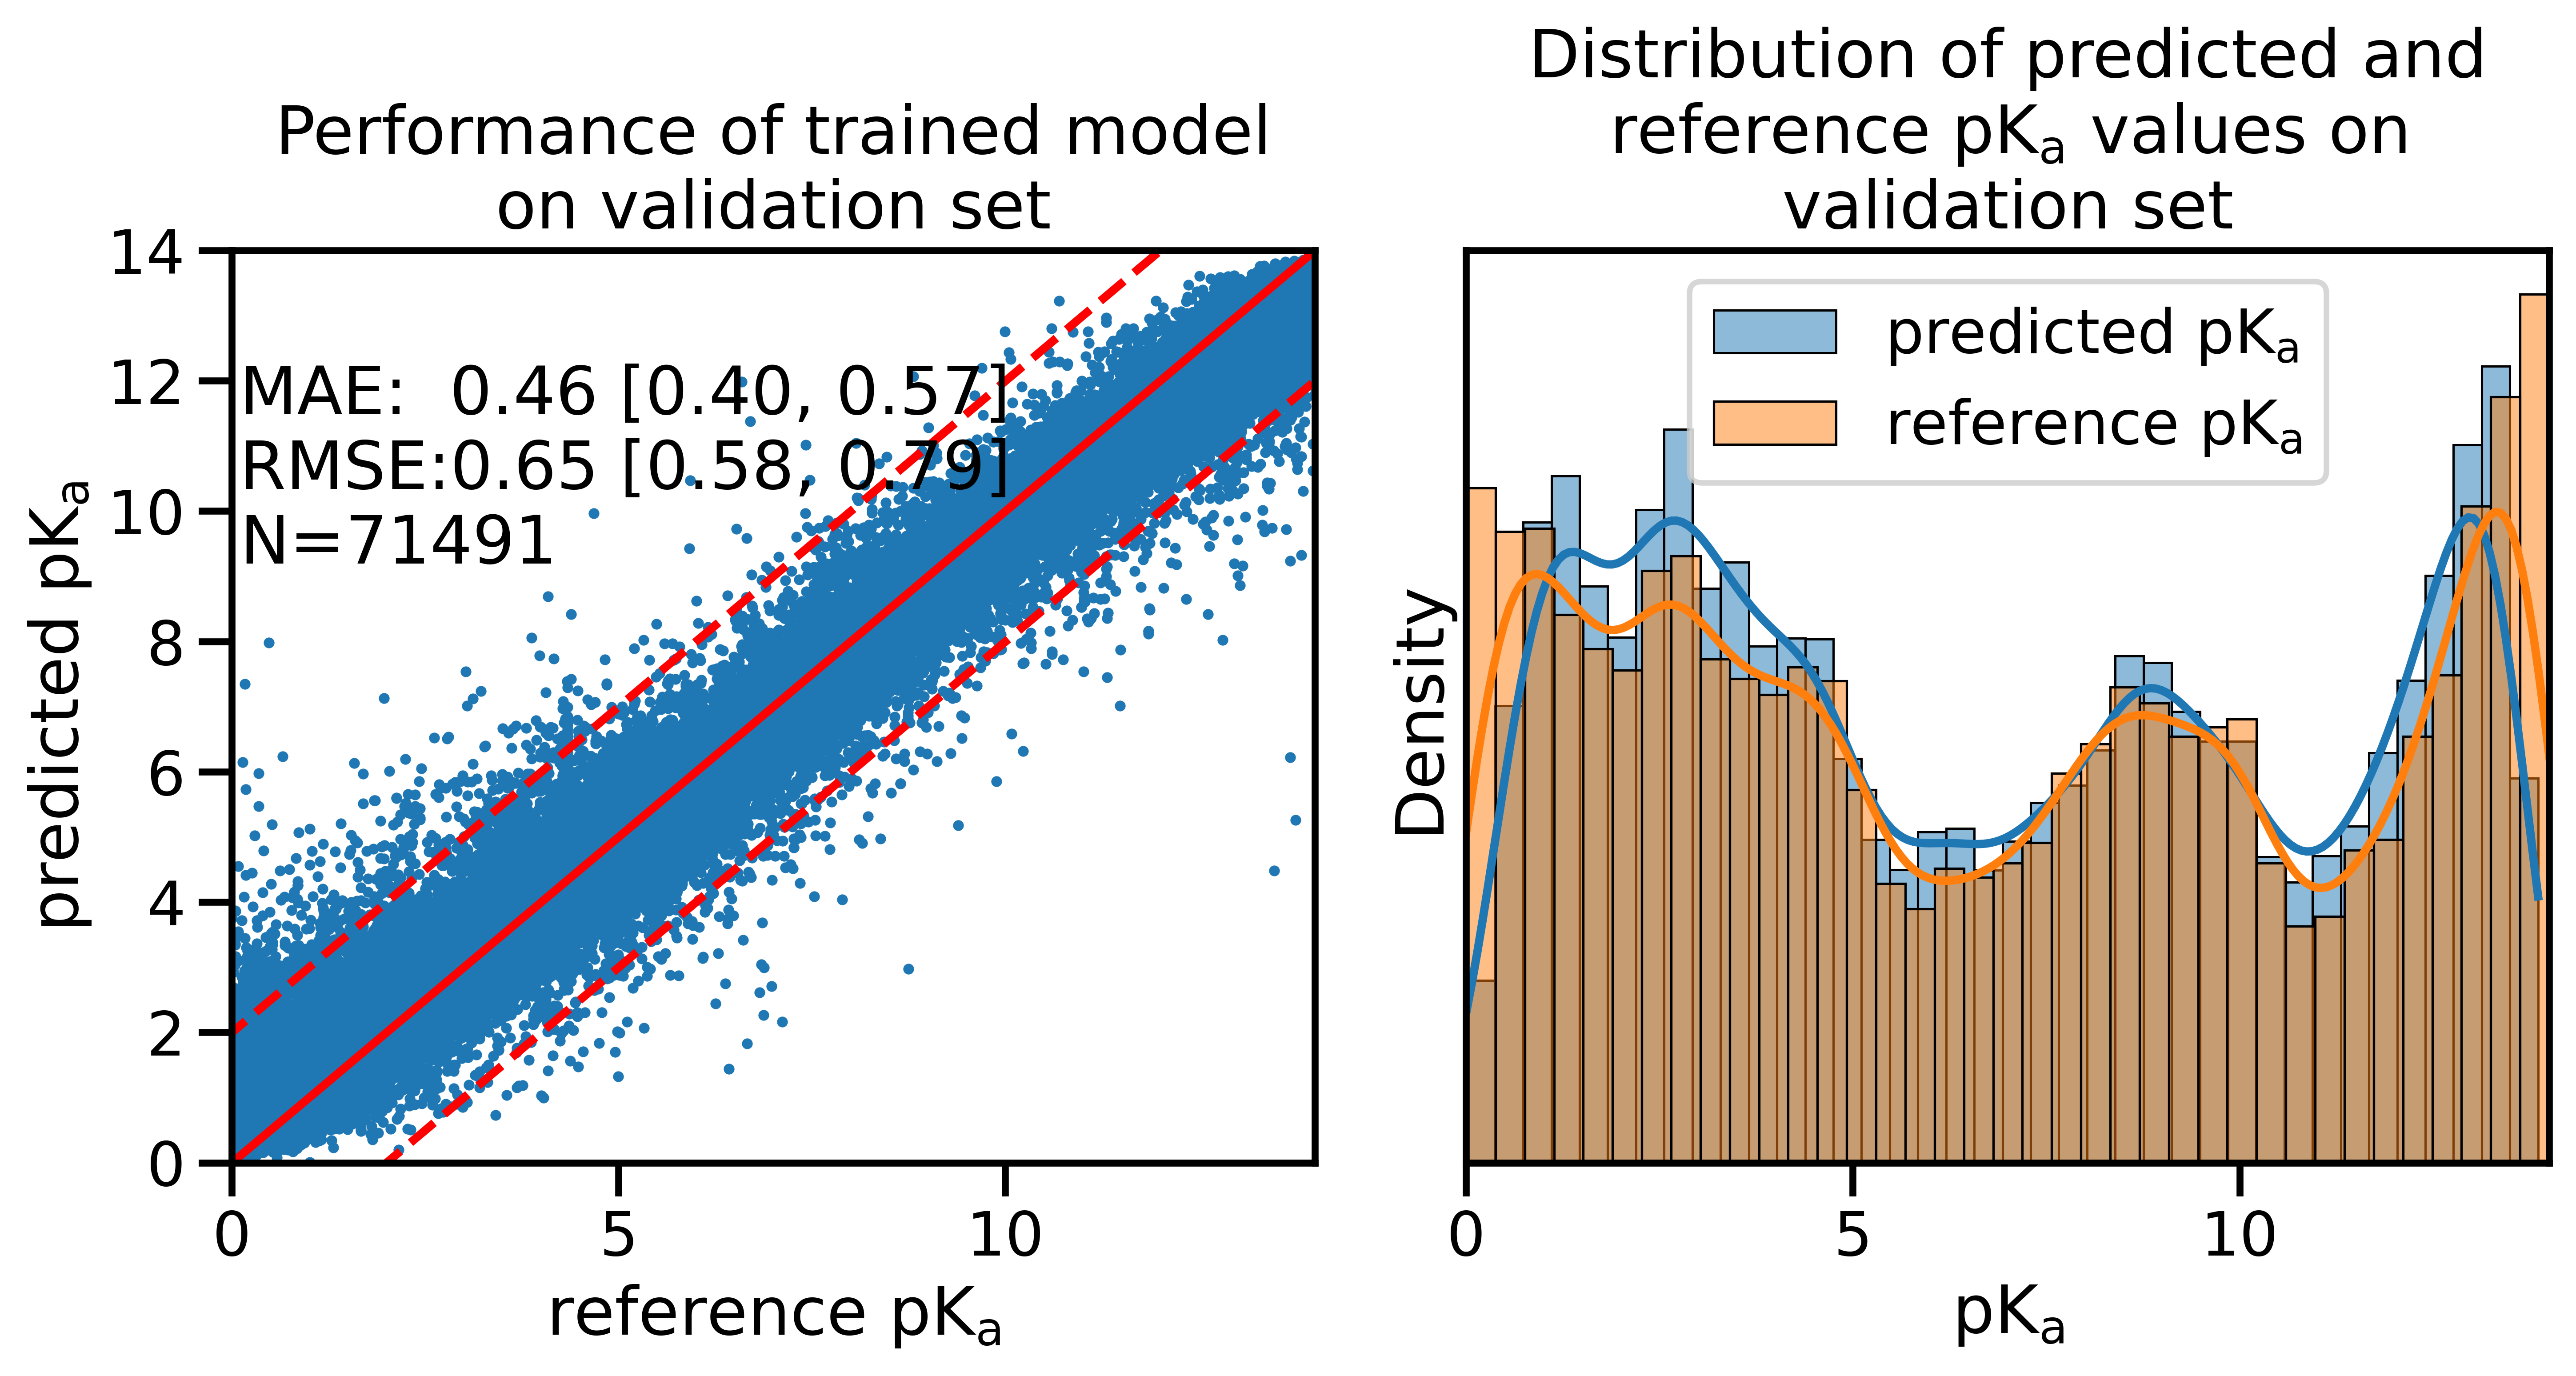

In [8]:
# performance of fine tuned models on initial training set
model = model_class(
    num_node_features, num_edge_features, hidden_channels=hidden_channels
)

# plot performance of the trained model on the validation set
from sklearn.model_selection import train_test_split

# set up plot
sns.set_context("talk")
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]
fig, axs = plt.subplots(1,2, figsize=(10.0, 5.5), dpi=600)

r, val_x = [], []
r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/fine_tuned_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    _, validation_dataset = train_test_split(
                training_dataset, test_size=0.1, shuffle=True, random_state=rs
    )
    data = dataset_to_dataloader(validation_dataset, BATCH_SIZE, shuffle=False)    
    x, y = calculate_performance_of_model_on_data(model, data)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# plot
axs[0].scatter(val_x[0], r[0], c=c1, marker='o', s=2, alpha=1.)
axs[0].set_title('Performance of trained model\non validation set')
axs[1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'validation set')
axs[0].set_xlim(0,14)
axs[0].set_ylim(0,14)
axs[0].set_xlabel(r'reference pK$_{a}$')
axs[0].set_ylabel(r'predicted pK$_{a}$')
axs[0].plot([0, 14], [0, 14], c='r')
axs[0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[1].set_xlim(0,14)
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel("Density")
axs[1].set_xlabel(r'pK$_{a}$')

plt.tight_layout()
plt.legend()
plt.savefig('plots/fine_tuned_model_on_pretrain_validation_set.png')
plt.show()

Attention pooling: False


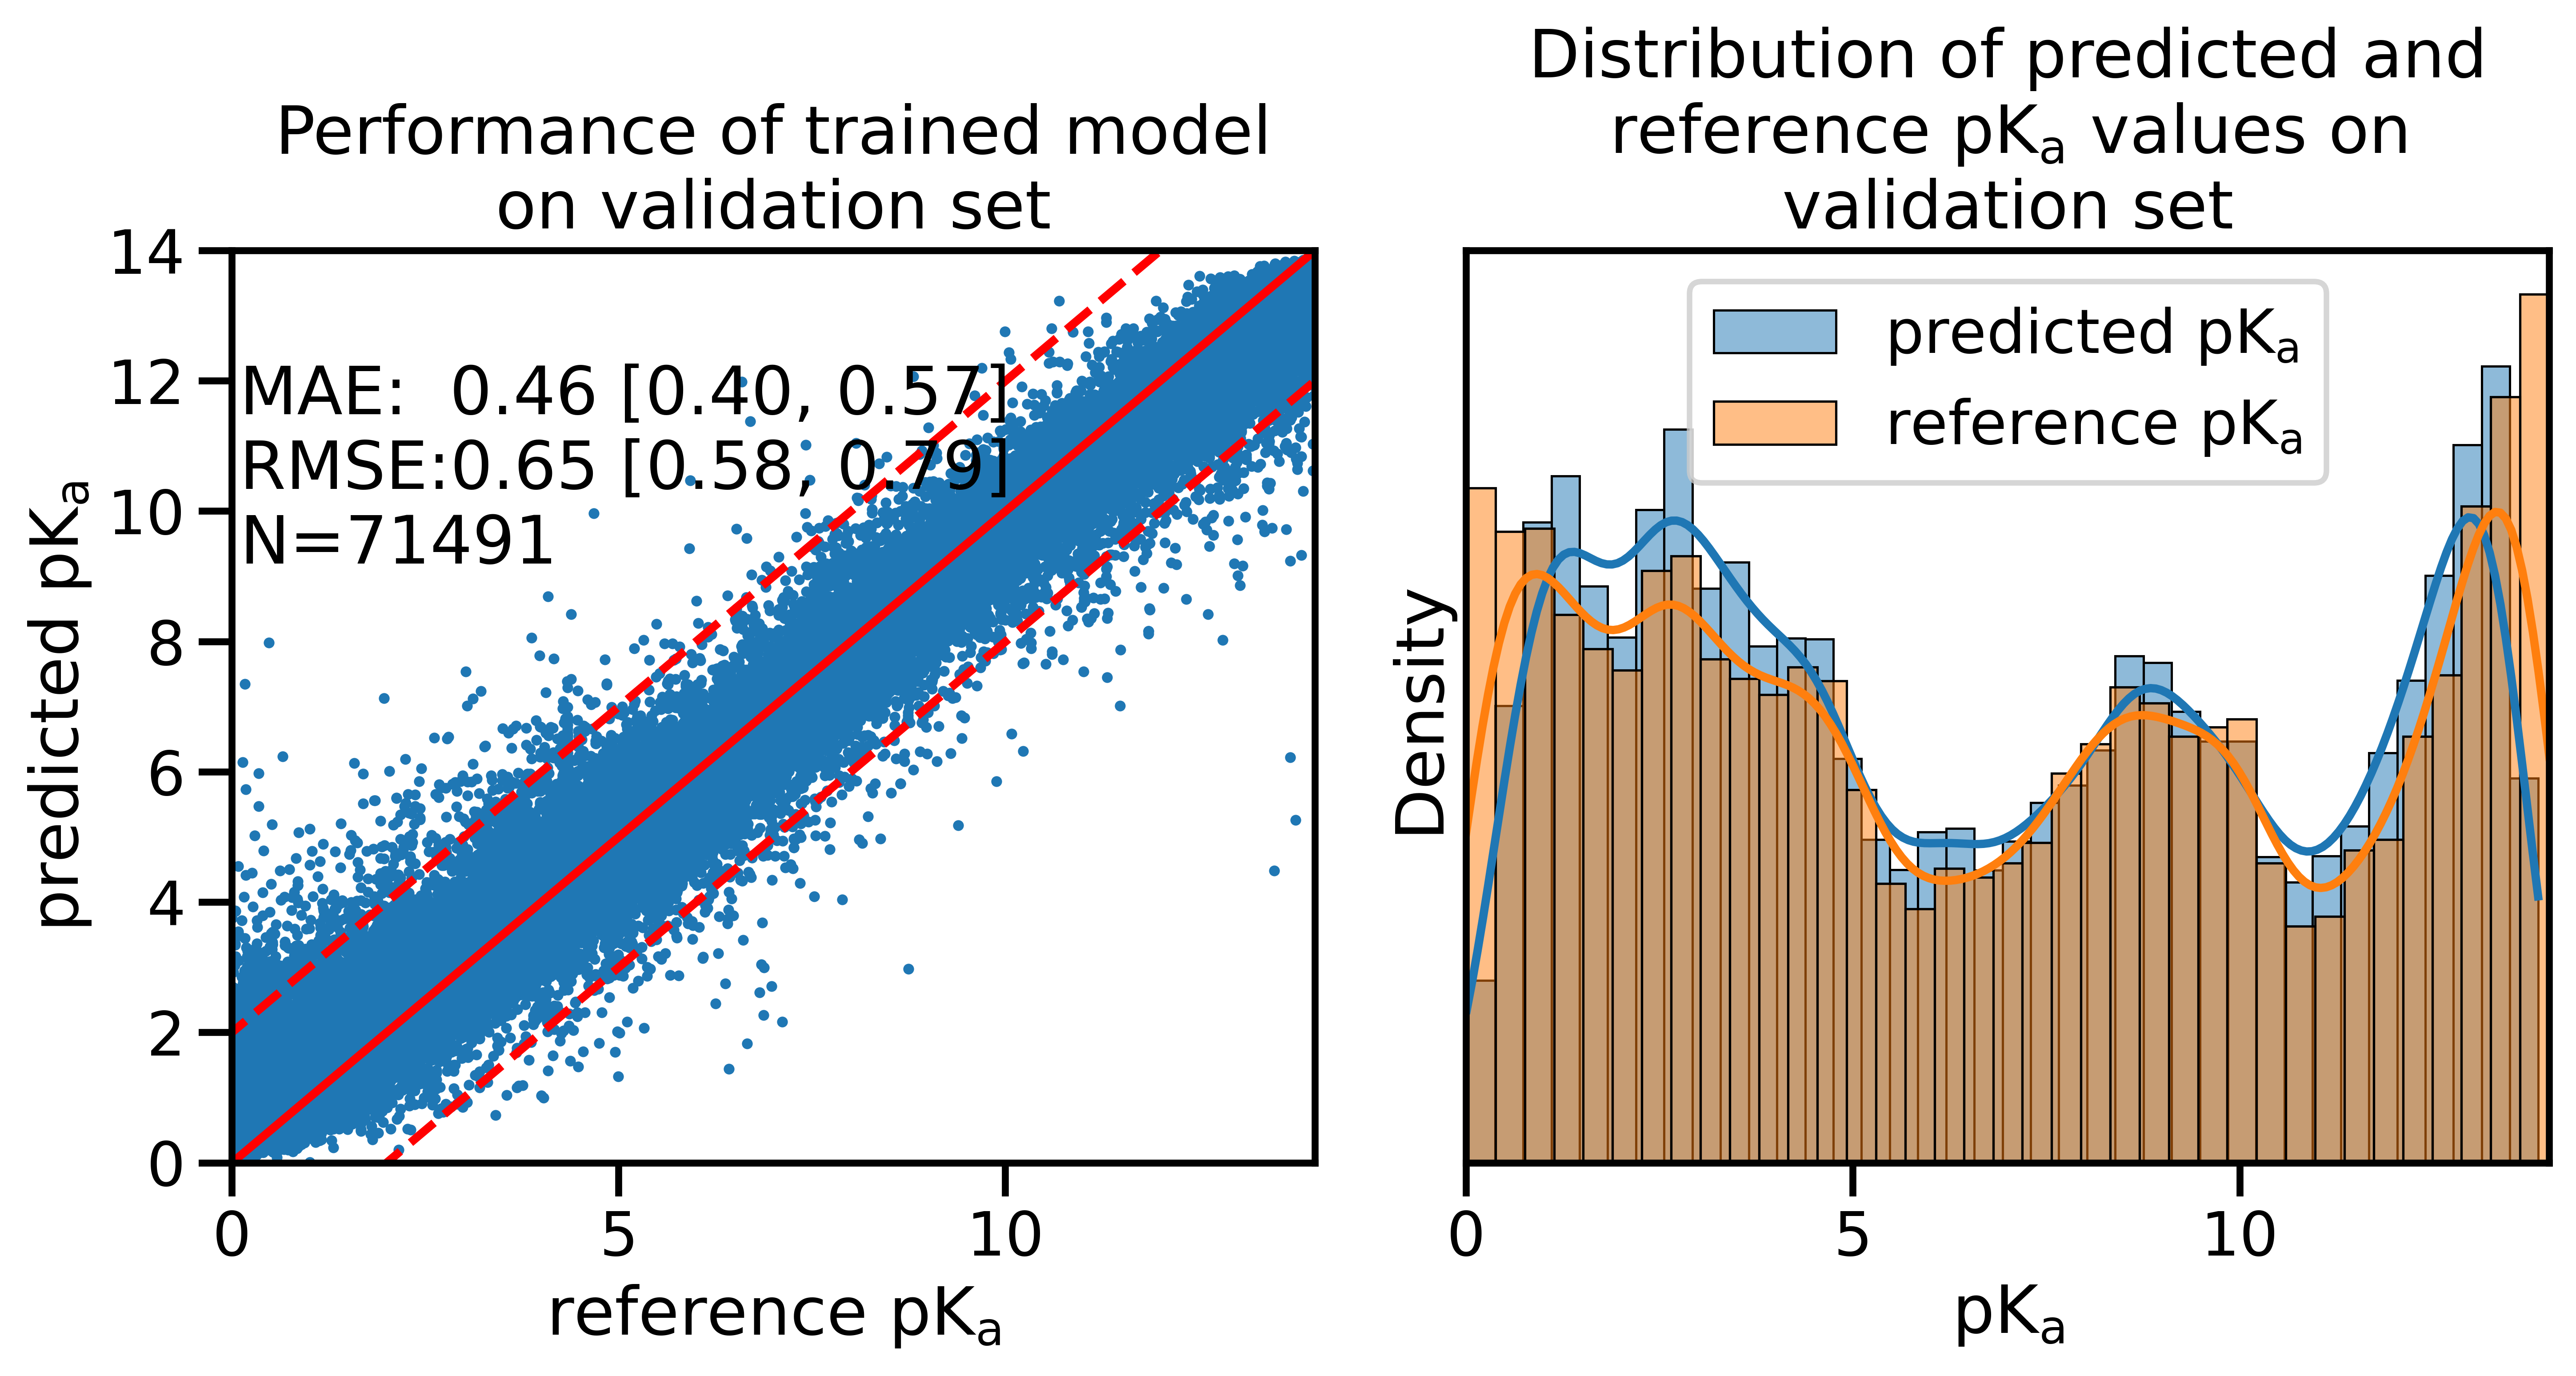

In [9]:
# performance of fine tuned models on initial training set
model = model_class(
    num_node_features, num_edge_features, hidden_channels=hidden_channels
)

# plot performance of the trained model on the validation set
from sklearn.model_selection import train_test_split

# set up plot
sns.set_context("talk")
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()
c1, c2 = palett_as_hex[0], palett_as_hex[1]
fig, axs = plt.subplots(1,2, figsize=(10.0, 5.5), dpi=600)

r, val_x = [], []
r, val_x = [], []
for i in range(nr_of_training_runs):
    base = f'{wdr_dir}/trained_models/training_run_{i}/'
    checkpoint = torch.load(f"{base}/fine_tuned_best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device=DEVICE)
    rs = pickle.load(open(f"{base}/randint.pkl", "rb"))
    _, validation_dataset = train_test_split(
                training_dataset, test_size=0.1, shuffle=True, random_state=rs
    )
    data = dataset_to_dataloader(validation_dataset, BATCH_SIZE, shuffle=False)    
    x, y = calculate_performance_of_model_on_data(model, data)
    r.append(np.array(y))
    val_x.append(x)

# calculate mae and rmse inclusive CI on the validation set
list_of_maes = []
for i in range(nr_of_training_runs):
    list_of_maes.append(mean_absolute_error(r[i], val_x[i]))
mae, mae_lower, mae_upper = confidence_calculation(list_of_maes)
list_of_rmses = []
for i in range(nr_of_training_runs):
    list_of_rmses.append(np.sqrt(mean_squared_error(r[i], val_x[i])))
rmse, rmse_lower, rmse_upper = confidence_calculation(list_of_rmses)

# plot
axs[0].scatter(val_x[0], r[0], c=c1, marker='o', s=2, alpha=1.)
axs[0].set_title('Performance of trained model\non validation set')
axs[1].set_title('Distribution of predicted and'+'\n'+r'reference pK$_{a}$ values on'+'\n' + 'validation set')
axs[0].set_xlim(0,14)
axs[0].set_ylim(0,14)
axs[0].set_xlabel(r'reference pK$_{a}$')
axs[0].set_ylabel(r'predicted pK$_{a}$')
axs[0].plot([0, 14], [0, 14], c='r')
axs[0].plot([1, 15], [-1, 13], c='r', ls="--")
axs[0].plot([-1, 13], [1, 15], c='r', ls="--")
axs[0].text(0.1,9.2,fr'MAE:  {round(mae, 2):.2f} [{round(mae_lower,2):.2f}, {round(mae_upper,2):.2f}]'+'\n'+fr'RMSE:{round(rmse, 2):.2f} [{round(rmse_lower,2):.2f}, {round(rmse_upper,2):.2f}]'+'\n'+f'N={len(r[0])}')
sns.histplot(r[0], color=c1, alpha=0.5, ax=axs[1], kde=True,stat='density', label=r'predicted pK$_{a}$',)
sns.histplot(val_x[0], color=c2, alpha=0.5,ax=axs[1], kde=True,stat='density', label=r'reference pK$_{a}$')
axs[1].set_xlim(0,14)
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel("Density")
axs[1].set_xlabel(r'pK$_{a}$')

plt.tight_layout()
plt.legend()
plt.savefig('plots/fine_tuned_model_on_pretrain_validation_set.png')
plt.show()